### Librerias

In [65]:
# Standard imports
import numpy as np
import os
import pandas as pd
import sys
import torch
import torch.nn.functional as F

# Visualization imports
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import seaborn as sns

# Machine learning imports
from scipy import stats
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae, r2_score
from torch import nn
from utils.models import GWGCN, GCN
from utils.laplacian import prepare_adjacency_matrix, check_symmetric

# Spatial analysis imports
import esda
import geopandas as gpd
import skgstat as skg
import splot.esda as esdaplot
from esda.getisord import G_Local
from esda.moran import Moran_Local
from libpysal.weights import lag_spatial
from shapely.geometry import Point

### Configuración

Vamos a configurar CUDA para aprovechar la GPU.

In [66]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.backends.cuda.matmul.fp32_precision = (
    "ieee"  # torch.backends.cuda.matmul.allow_tf32 = True
)
torch.backends.cudnn.conv.fp32_precision = (
    "tf32"  # torch.backends.cudnn.allow_tf32 = True
)
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [67]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION", torch.version.cuda
)
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())
#! nvidia-smi

__Python VERSION: 3.12.11 (main, Sep  5 2025, 19:35:43) [GCC 13.3.0]
__pyTorch VERSION: 2.9.0+cu128
__CUDA VERSION 12.8
__CUDNN VERSION: 91002
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


Configuramos un diccionaro con algunas variables que usaremos durante el entrenamiento:

In [68]:
# Configuration dictionary
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "graph": {
        "adj": {
            "k": 20,
        },
    },
    "model": {
        "hidden_layers": [16],
        "dropouts": [0.3],
        "learning_rate": 1e-3,
        "weight_decay_ratio": 1,
    },
    "training": {
        "epochs": 20000,
        "print_interval": 1000,
        "error_type": "MSE"
    },
}

In [69]:
device = config['device']
device

device(type='cuda')

In [70]:
def step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> float:
    """
    Perform a training step with the given model and optimizer.
    Trains the model on the specified indices.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the training samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        float: The mean loss value for the training step.
    """
    model.train()
    optimizer.zero_grad()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx])
    loss.backward()
    optimizer.step()
    return loss.item()

In [71]:
def evaluate_error(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
    error_type: str,
) -> float:
    """
    Evaluate the model's performance on a validation set using a user defined rror.

    Args:
        model (nn.Module): The neural network model to evaluate.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the validation samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.
        error_type(str): The error type to use. Can be "MSE" or "MAPE".

    Returns:
        float: The mean loss on the validation set.
    """
    model.eval()
    # with torch.no_grad():
    with torch.inference_mode():
        output = model(input_tensor, adj)
        preds = output[idx]
        targets = target_tensor[idx]
        if error_type == "MSE":
            error = F.mse_loss(preds, targets)
        elif error_type == "RMSE":
            error = torch.sqrt(F.mse_loss(preds, targets))
        else:
            raise ValueError("Invalid error type. Must be 'MSE' or 'RSME'.")
    return error.item()

In [72]:
def return_results(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate and return the model's predictions and corresponding targets.

    Args:
        model (nn.Module): The trained neural network model.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices for which to generate predictions.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted values
        and the ground truth values as NumPy arrays.
    """
    model.eval()
    # with torch.no_grad():
    with torch.inference_mode():
        output = model(input_tensor, adj)
    predictions = output[idx].cpu().detach().numpy()
    targets = target_tensor[idx].cpu().detach().numpy()
    return predictions, targets

#### Carga de Datos

In [73]:
db = pd.read_csv("well_frac_prod_data_VM.csv")
db = db.convert_dtypes()
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   well_id               1763 non-null   Int64  
 1   month_x               1763 non-null   Int64  
 2   year_x                1763 non-null   Int64  
 3   well_name             1763 non-null   string 
 4   company               1763 non-null   string 
 5   basin_x               1763 non-null   string 
 6   field                 1763 non-null   string 
 7   formation_x           1763 non-null   string 
 8   reservoir_type        1763 non-null   string 
 9   reservoir_subtype     1763 non-null   string 
 10  lateral_length_ft     1763 non-null   Float64
 11  number_stages         1763 non-null   Int64  
 12  proppant_pumped_lb    1763 non-null   Float64
 13  fluid_pumped_bbl      1763 non-null   Float64
 14  maximum_pressure_psi  1763 non-null   Float64
 15  horse_power_hp       

In [74]:
db.columns

Index(['well_id', 'month_x', 'year_x', 'well_name', 'company', 'basin_x',
       'field', 'formation_x', 'reservoir_type', 'reservoir_subtype',
       'lateral_length_ft', 'number_stages', 'proppant_pumped_lb',
       'fluid_pumped_bbl', 'maximum_pressure_psi', 'horse_power_hp',
       'company_id', 'year_y', 'month_y', 'oil_prod_m3', 'gas_prod_km3',
       'water_prod_m3', 'water_inj_m3', 'well_type', 'entry_date', 'depth_m',
       'formation_y', 'basin_y', 'province', 'Xcoor', 'Ycoor', 'month_count',
       'cum_oil_m3', 'cum_gas_km3', 'cum_water_m3', 'cum_oil_km3',
       'cum_gas_Mm3', 'cum_water_km3'],
      dtype='object')

In [75]:
db.head()

well_id  month_x  year_x            well_name   company   basin_x  \
0   159219       11    2017  YPF.Nq.AdlA-1001(h)  YPF S.A.  NEUQUINA   
1   159220       11    2017  YPF.Nq.AdlA-1002(h)  YPF S.A.  NEUQUINA   
2   159221       11    2017  YPF.Nq.AdlA-1003(h)  YPF S.A.  NEUQUINA   
3   160426        1    2019  YPF.Nq.AdlA-1004(h)  YPF S.A.  NEUQUINA   
4   160518        1    2019  YPF.Nq.AdlA-1005(h)  YPF S.A.  NEUQUINA   

                field  formation_x   reservoir_type reservoir_subtype  ...  \
0  AGUADA DE LA ARENA  vaca muerta  NO CONVENCIONAL             SHALE  ...   
1  AGUADA DE LA ARENA  vaca muerta  NO CONVENCIONAL             SHALE  ...   
2  AGUADA DE LA ARENA  vaca muerta  NO CONVENCIONAL             SHALE  ...   
3  AGUADA DE LA ARENA  vaca muerta  NO CONVENCIONAL             SHALE  ...   
4  AGUADA DE LA ARENA  vaca muerta  NO CONVENCIONAL             SHALE  ...   

   province      Xcoor      Ycoor  month_count  cum_oil_m3  cum_gas_km3  \
0   Neuquén -69.159188 -38.221866           12      511.54     51835.62   
1   Neuquén -69.159074 -38.221864           12      134.67     28554.12   
2   Neuquén -69.158959 -38.221862           12      573.69     36643.61   
3   Neuquén -69.157819 -38.223443           12        45.2      3567.46   
4   Neuquén -69.157704 -38.223443           12        2.74      26657.5   

  cum_water_m3  cum_oil_km3  cum_gas_Mm3  cum_water_km3  
0      2692.56      0.51154     51.83562        2.69256  
1      6127.94      0.13467     28.55412        6.12794  
2      2525.03      0.57369     36.64361        2.52503  
3        743.6       0.0452      3.56746         0.7436  
4      10144.2      0.00274      26.6575        10.1442  

[5 rows x 38 columns]

In [76]:
# 1. Summary Statistics
summary_stats = db.describe()

# 2. Missing Values Check
missing_values = db.isnull().sum()

# 3. Correlation Matrix
correlation_matrix = db.select_dtypes(include=[np.number]).corr()

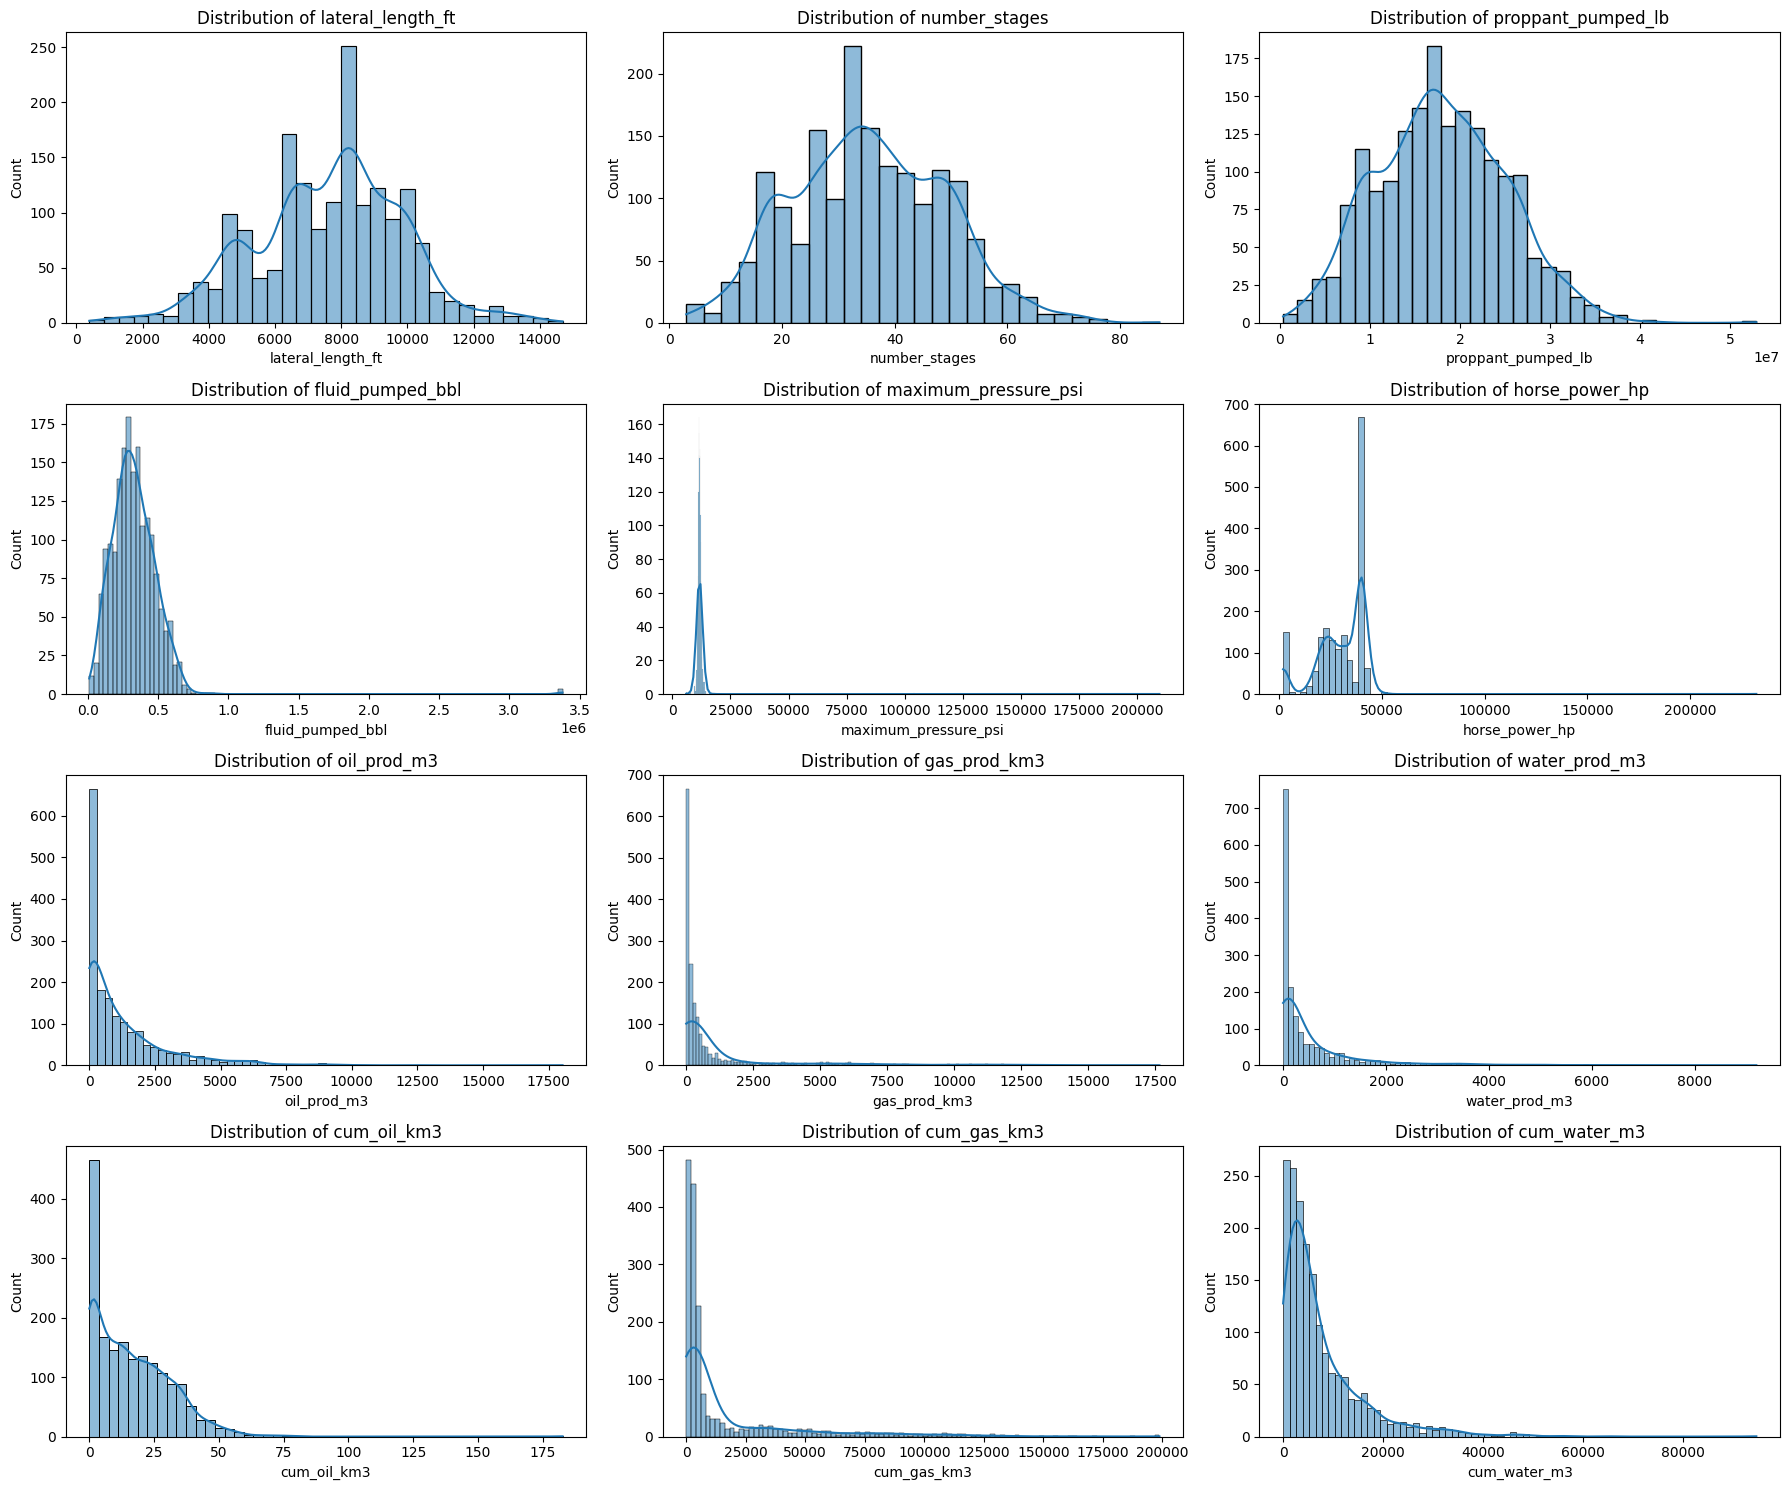

In [77]:
# Plotting
# Numerical Feature Distributions
numerical_features = [
    "lateral_length_ft",
    "number_stages",
    "proppant_pumped_lb",
    "fluid_pumped_bbl",
    "maximum_pressure_psi",
    "horse_power_hp",
    "oil_prod_m3",
    "gas_prod_km3",
    "water_prod_m3",
    "cum_oil_km3",
    "cum_gas_km3",
    "cum_water_m3",
]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
for ax, feature in zip(axes.flatten(), numerical_features):
    sns.histplot(db[feature], kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    plt.tight_layout()
plt.show()

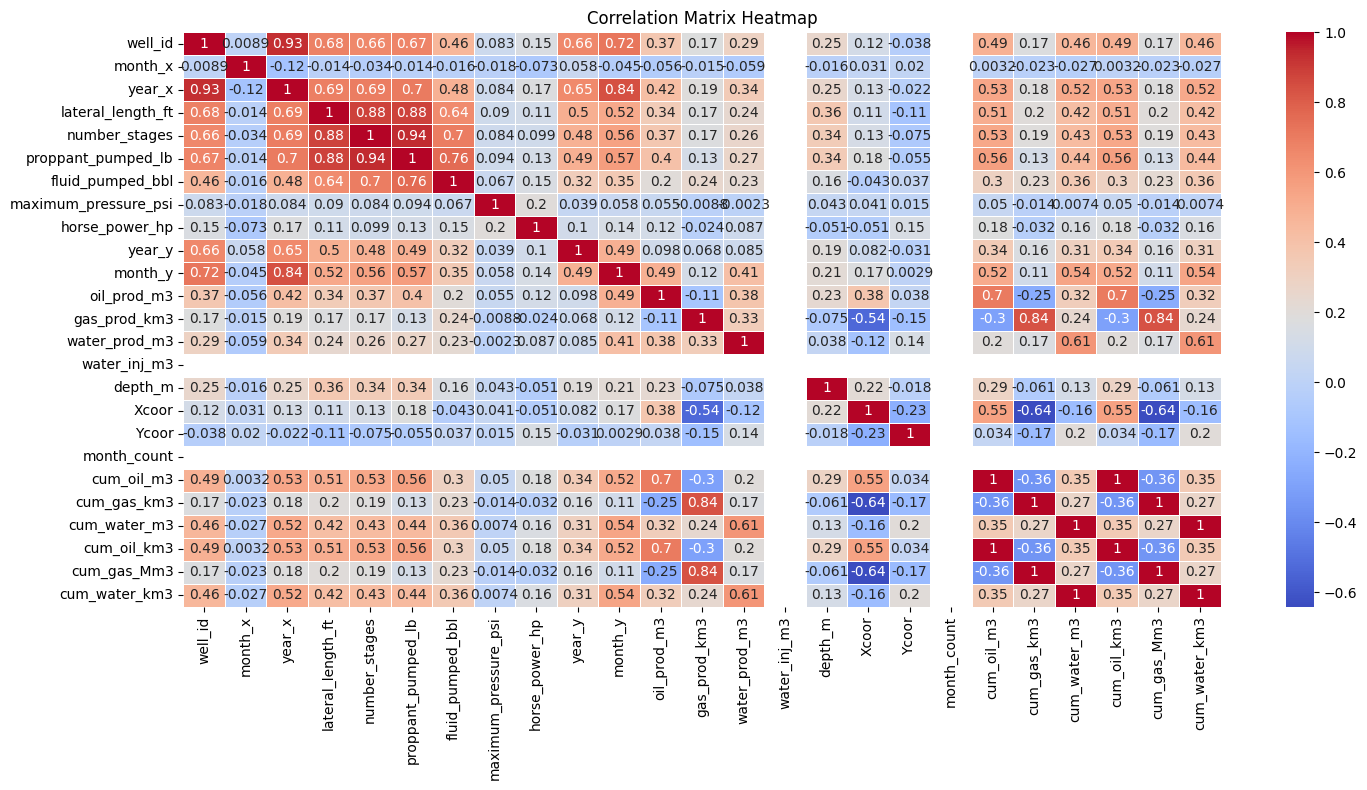

In [78]:
# Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [79]:
summary_stats

well_id   month_x       year_x  lateral_length_ft  number_stages  \
count         1763.0    1763.0       1763.0             1763.0         1763.0   
mean   161951.839478   6.45831  2020.471923        7627.623387      35.355644   
std      3431.955313  3.369228     2.779992        2216.230031        13.4181   
min         137008.0       1.0       2011.0            390.439            3.0   
25%         160056.5       4.0       2018.0           6404.512           26.0   
50%         162780.0       6.0       2021.0           7920.334           35.0   
75%         164447.5       9.0       2023.0             9186.8           45.5   
max         165757.0      12.0       2025.0          14689.037           87.0   

       proppant_pumped_lb  fluid_pumped_bbl  maximum_pressure_psi  \
count              1763.0            1763.0                1763.0   
mean        17970376.4726     328873.012995           11836.43911   
std        7107426.013915     189441.487645           5260.295877   
min             368171.54      10164.339424               5946.93   
25%        13014419.70807     223946.431051          11270.640719   
50%        17646377.03433     312965.272837          11650.198264   
75%       22929452.894095     424006.398866               12071.5   
max         52911078.4158    3378791.217664         209640.559334   

       horse_power_hp       year_y  ...      depth_m      Xcoor      Ycoor  \
count          1763.0       1763.0  ...       1763.0     1763.0     1763.0   
mean     30081.815253  2023.191151  ...   5247.15325 -68.811229 -38.282568   
std      12721.610705      1.94688  ...  1378.606364   0.292798   0.221508   
min            2000.0       2008.0  ...          0.0 -69.696267 -38.833272   
25%           22995.5       2022.0  ...     4907.505 -69.070423 -38.390287   
50%           32000.0       2024.0  ...      5512.63 -68.687044  -38.33018   
75%           40000.0       2025.0  ...       5998.0 -68.602989 -38.210629   
max       232159.2892       2025.0  ...       7784.0 -68.294423 -37.085457   

       month_count    cum_oil_m3   cum_gas_km3  cum_water_m3  cum_oil_km3  \
count       1763.0        1763.0        1763.0        1763.0       1763.0   
mean          12.0    16294.3776  16484.711129    7633.02571    16.294378   
std            0.0  14956.403176  28549.007565   8534.803398    14.956403   
min           12.0           0.0           0.0           0.0          0.0   
25%           12.0   3207.050615       1840.57     2189.1625     3.207051   
50%           12.0      13354.89       3742.39      4791.769     13.35489   
75%           12.0     25915.833      14197.96     10100.335    25.915833   
max           12.0    182645.925    198749.105     94675.383   182.645925   

       cum_gas_Mm3  cum_water_km3  
count       1763.0         1763.0  
mean     16.484711       7.633026  
std      28.549008       8.534803  
min            0.0            0.0  
25%        1.84057       2.189163  
50%        3.74239       4.791769  
75%       14.19796      10.100335  
max     198.749105      94.675383  

[8 rows x 25 columns]

In [80]:
laplacian_knn, knn, a_knn_connected = prepare_adjacency_matrix(db, config['graph']['adj']['k'], True, 'hard')

The weights matrix is fully connected.


In [81]:
check_symmetric(np.array(laplacian_knn))

True

Veamos el resultado de la construcción del grafo:

In [82]:
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(a_knn_connected)

# Extract coordinates from 'Xcoor' and 'Ycoor' columns
positions = {i: (row["Xcoor"], row["Ycoor"]) for i, row in db.iterrows()}

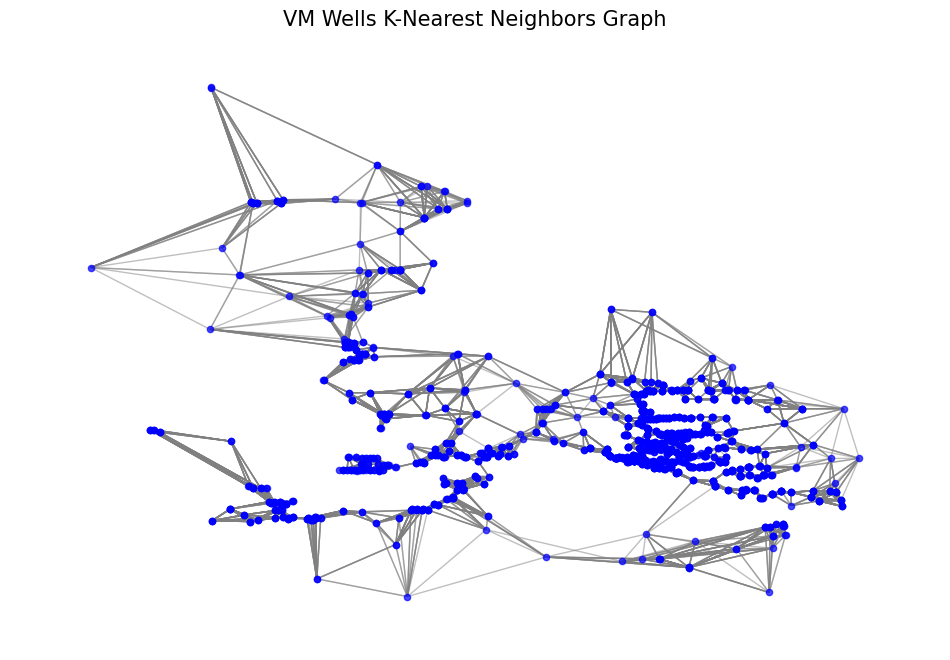

In [83]:
# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos=positions, alpha=0.5, edge_color="gray")
nx.draw_networkx_nodes(G, pos=positions, node_size=20, node_color="blue", alpha=0.7)
plt.axis("off")
plt.title("VM Wells K-Nearest Neighbors Graph", fontsize=15)
plt.show()

Podemos graficar de manera interactiva:

In [84]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [positions[node][0] for node in G.nodes()]
node_y = [positions[node][1] for node in G.nodes()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=5,
        color=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Coloring nodes based on degree
node_adjacencies = [G.degree(node) for node in G.nodes()]
node_trace.marker.color = node_adjacencies

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='VM Wells K-Nearest Neighbors Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

In [85]:
adj = torch.FloatTensor(laplacian_knn).to(device)

In [86]:
# the list of independent variables used for regression (may be used for feature engineering)
variable_names = [
    "lateral_length_ft",
    "number_stages",
    "proppant_pumped_lb",
    "fluid_pumped_bbl",
    "gas_prod_km3",
    "oil_prod_m3",
    "water_prod_m3",
    "depth_m",
    "cum_gas_Mm3",
    "cum_water_km3",
]


# Min-Max scaling function
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())


# Apply Min-Max scaling to each feature
for var in variable_names:
    if var in db.columns:
        # Convert to float and apply scaling
        db[var] = min_max_scale(db[var])

In [87]:
# db["cum_oil_km3"] = np.log1p(db["cum_oil_km3"])
db["cum_oil_km3"] = min_max_scale(db["cum_oil_km3"])

In [88]:
### Params settings for the model on limited Xs
n_labels = 1  # #output feature dimension
n_features = len(variable_names)  # #input feature dimensional vector
num_nodes = adj.size(0)

In [89]:
N = len(db)
perm = torch.randperm(N, device=device)
split_test = 0.75
split_val = 0.05
n_train = int(split_test * N)
n_test = N - n_train
n_val = int(split_val * n_train)

idx_train = perm[:n_train]
idx_val = perm[n_train : n_train + n_val]
idx_test = perm[n_train + n_val :]

In [90]:
print(f"n_train: {n_train}, n_val: {n_val}, n_test: {n_test}")

n_train: 1322, n_val: 66, n_test: 441


In [91]:
### The observations for data regression
x_tensor = torch.FloatTensor(db[variable_names].values.tolist()).to(device)
y_tensor = torch.FloatTensor(db[['cum_oil_km3']].values.tolist()).to(device)
idx_all = torch.LongTensor(db.index.values).to(device)

In [92]:
class ModelFactory:
    """Factory class to create different types of GCN models."""

    @staticmethod
    def create(
        model_type: str,
        in_features: int,
        out_features: int,
        hidden: list,
        dropouts: list,
        num_nodes: int
    ) -> nn.Module:
        if model_type == "GCN":
            return GCN(in_features, out_features, hidden, dropouts).to(device)
        elif model_type == "GWGCN":
            return GWGCN(
                in_features, out_features, hidden, dropouts, num_nodes
            ).to(device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

#### Training

In [93]:
model_type = "GWGCN"  # or "GCN"
model = ModelFactory.create(
    model_type,
    n_features,
    n_labels,
    config["model"]["hidden_layers"],
    config["model"]['dropouts'],
    num_nodes
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["model"]["learning_rate"],
    weight_decay=config["model"]["learning_rate"] * config["model"]["weight_decay_ratio"],
    amsgrad=False
)

In [94]:
lowest_mean_val_error = np.inf
min_val_erroroch = -1
train_loss_arr = []
error_arr = []

for i in range(config["training"]["epochs"]):
    train_loss = step(model, optimizer, x_tensor, idx_train, y_tensor, adj)
    train_loss_arr.append(train_loss)
    val_error = evaluate_error(
        model, x_tensor, idx_val, y_tensor, adj, config["training"]["error_type"]
    )
    error_arr.append(val_error)

    if val_error < lowest_mean_val_error:
        lowest_mean_val_error = val_error
        min_val_error_epoch = i

    if (
        i % config["training"]["print_interval"] == 0
        or i == config["training"]["epochs"] - 1
    ):
        print(
            f"epoch: {i} --train_loss: {train_loss:.4f} --val_error: {val_error:.4f}"
        )

epoch: 0 --train_loss: 1450.9104 --val_error: 1526.3094


epoch: 1000 --train_loss: 14.1152 --val_error: 15.6611
epoch: 2000 --train_loss: 0.7758 --val_error: 0.9551
epoch: 3000 --train_loss: 0.1310 --val_error: 0.1577
epoch: 4000 --train_loss: 0.0518 --val_error: 0.0714
epoch: 5000 --train_loss: 0.0253 --val_error: 0.0410
epoch: 6000 --train_loss: 0.0132 --val_error: 0.0217
epoch: 7000 --train_loss: 0.0091 --val_error: 0.0134
epoch: 8000 --train_loss: 0.0071 --val_error: 0.0090
epoch: 9000 --train_loss: 0.0060 --val_error: 0.0081
epoch: 10000 --train_loss: 0.0055 --val_error: 0.0074
epoch: 11000 --train_loss: 0.0049 --val_error: 0.0064
epoch: 12000 --train_loss: 0.0041 --val_error: 0.0056
epoch: 13000 --train_loss: 0.0038 --val_error: 0.0050
epoch: 14000 --train_loss: 0.0031 --val_error: 0.0043
epoch: 15000 --train_loss: 0.0028 --val_error: 0.0039
epoch: 16000 --train_loss: 0.0024 --val_error: 0.0035
epoch: 17000 --train_loss: 0.0023 --val_error: 0.0034
epoch: 18000 --train_loss: 0.0022 --val_error: 0.0032
epoch: 19000 --train_loss: 0.0020 -

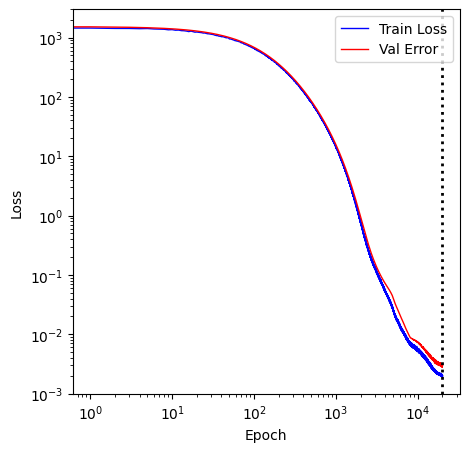

In [95]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(train_loss_arr, lw=1, color="b", alpha=1, label="Train Loss")
ax.plot(error_arr, lw=1, color="r", alpha=1, label="Val Error")
ax.set_xlabel("Epoch")
ax.set_xscale("log")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend(loc='upper right')
plt.axvline(min_val_error_epoch, linestyle="dotted", linewidth=2, color="black")
plt.show()

In [96]:
output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)

In [97]:
idx_train = idx_train.cpu().detach().numpy()
idx_test = idx_test.cpu().detach().numpy()

In [98]:
output_train, target_train = output[idx_train], target[idx_train]

In [99]:
print(f'MAE Train: {mae(output_train, target_train)}, MSE Train: {mse(output_train, target_train)}, RMSE Train: {np.sqrt(mse(output_train, target_train))}, R2 Train: {r2_score(target_train, output_train)}')

MAE Train: 0.02066522277891636, MSE Train: 0.0018510614754632115, RMSE Train: 0.0430239639673428, R2 Train: 0.7305301427841187


In [100]:
residuals_train = (output_train - target_train).flatten()

In [101]:
output_test, target_test = output[idx_test], target[idx_test]

In [102]:
print(f'MAE Test: {mae(output_test, target_test)}, MSE Test: {mse(output_test, target_test)}, RMSE Test: {np.sqrt(mse(output_test, target_test))}, R2 Test: {r2_score(target_test, output_test)}')

MAE Test: 0.022779472172260284, MSE Test: 0.002636388875544071, RMSE Test: 0.05134577758242708, R2 Test: 0.5507048964500427


In [103]:
residuals_test = (output_test - target_test).flatten()

In [104]:
residuals = np.zeros(N)
residuals[idx_train] = residuals_train
residuals[idx_test] = residuals_test

In [105]:
dbplot = db.loc[:, ["cum_oil_km3", "Xcoor", "Ycoor"]].copy()
dbplot["pred"] = np.squeeze(output)
dbplot["error"] = dbplot["pred"] - dbplot["cum_oil_km3"]
dbplot_train = dbplot.iloc[idx_train]
dbplot_test = dbplot.iloc[idx_test]

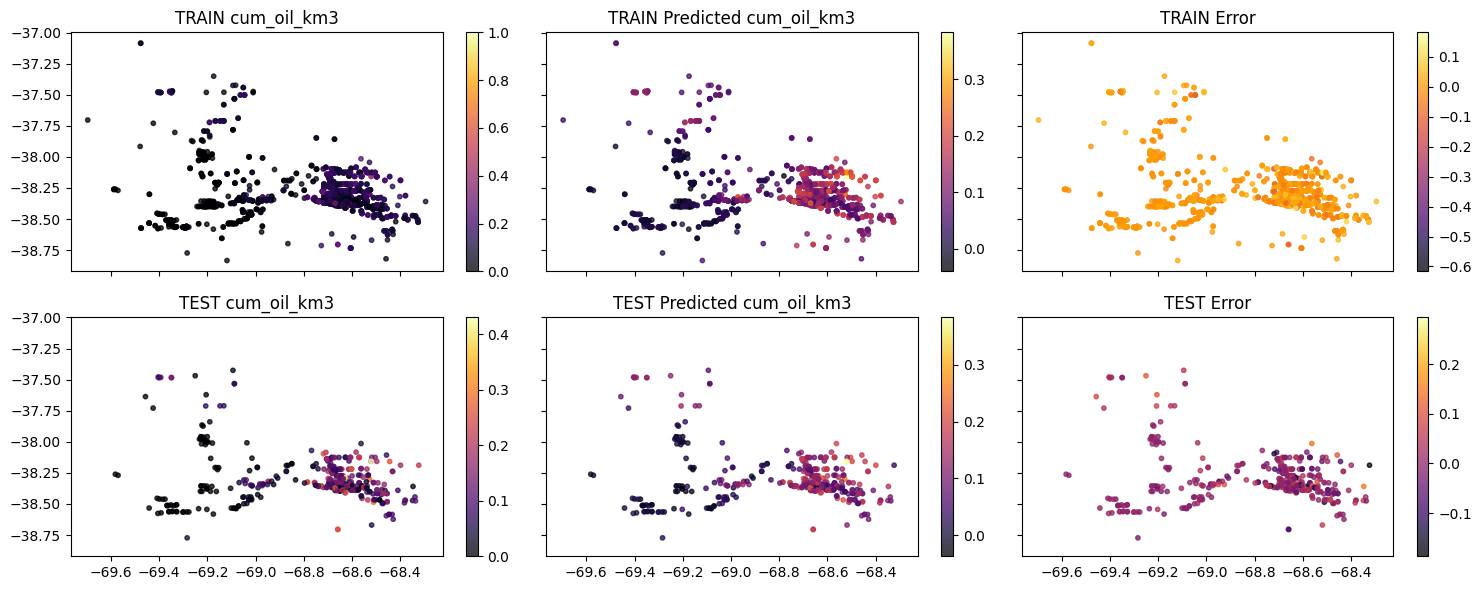

In [106]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
ax = ax.ravel()

scatter1 = ax[0].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["cum_oil_km3"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter1, ax=ax[0])
ax[0].set_title("TRAIN cum_oil_km3")

scatter2 = ax[1].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["pred"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter2, ax=ax[1])
ax[1].set_title("TRAIN Predicted cum_oil_km3")

scatter3 = ax[2].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["error"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter3, ax=ax[2])
ax[2].set_title("TRAIN Error")

scatter4 = ax[3].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["cum_oil_km3"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter4, ax=ax[3])
ax[3].set_title("TEST cum_oil_km3")

scatter5 = ax[4].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["pred"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter5, ax=ax[4])
ax[4].set_title("TEST Predicted cum_oil_km3")

scatter6 = ax[5].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["error"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter6, ax=ax[5])
ax[5].set_title("TEST Error")

plt.tight_layout()
plt.show()

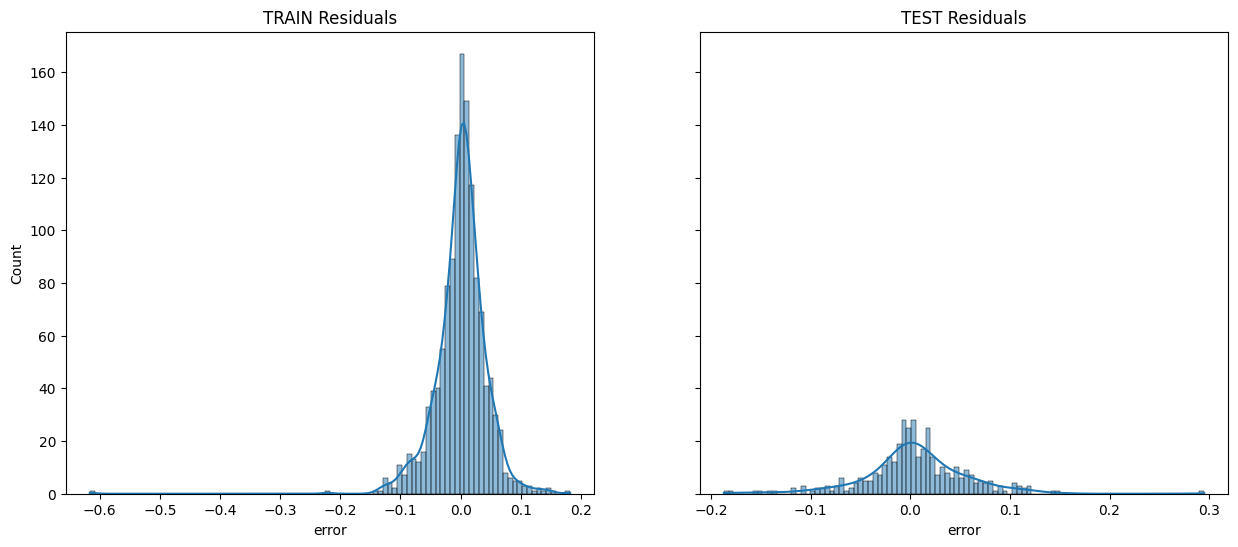

In [107]:
# Plot train-test hist results
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.histplot(dbplot_train["error"], bins=100, kde=True, ax=ax[0])
ax[0].set_title("TRAIN Residuals")
sns.histplot(dbplot_test["error"], bins=100, kde=True, ax=ax[1])
ax[1].set_title("TEST Residuals")

plt.show()

In [108]:
def normality_test(data, alpha=0.05):
    print("=== Normality Tests ===\n")

    # Helper for pass/fail
    def check_pvalue(p):
        return "PASSED normality ✓" if p > alpha else "FAILED normality ✗"

    # D'Agostino-Pearson
    stat, p = stats.normaltest(data)
    print("D'Agostino-Pearson Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Shapiro-Wilk
    stat, p = stats.shapiro(data)
    print("Shapiro-Wilk Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Kolmogorov-Smirnov (against standard normal)
    stat, p = stats.kstest(data, "norm")
    print("Kolmogorov-Smirnov Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Anderson-Darling
    result = stats.anderson(data)
    print("Anderson-Darling Test")
    print(f"  Statistic: {result.statistic:.4f}")

    # Check against critical values
    passed = []
    for sl, cv in zip(result.significance_level, result.critical_values):
        status = "PASSED" if result.statistic < cv else "FAILED"
        passed.append(result.statistic < cv)
        print(f"  At {sl}% level: critical={cv:.4f} → {status}")

    # Summary for Anderson
    if all(passed):
        print("  Overall Result: PASSED normality ✓")
    else:
        print("  Overall Result: FAILED normality ✗")

    print("\n=========================\n")

In [109]:
normality_test(dbplot_train["error"])

=== Normality Tests ===

D'Agostino-Pearson Test
  Statistic: 895.8370
  p-value:   0.0000
  Result:    FAILED normality ✗

Shapiro-Wilk Test
  Statistic: 0.8785
  p-value:   0.0000
  Result:    FAILED normality ✗

Kolmogorov-Smirnov Test
  Statistic: 0.4496
  p-value:   0.0000
  Result:    FAILED normality ✗

Anderson-Darling Test
  Statistic: 19.1595
  At 15.0% level: critical=0.5740 → FAILED
  At 10.0% level: critical=0.6540 → FAILED
  At 5.0% level: critical=0.7850 → FAILED
  At 2.5% level: critical=0.9150 → FAILED
  At 1.0% level: critical=1.0890 → FAILED
  Overall Result: FAILED normality ✗




In [110]:
normality_test(dbplot_test["error"])

=== Normality Tests ===

D'Agostino-Pearson Test
  Statistic: 39.4994
  p-value:   0.0000
  Result:    FAILED normality ✗

Shapiro-Wilk Test
  Statistic: 0.9495
  p-value:   0.0000
  Result:    FAILED normality ✗

Kolmogorov-Smirnov Test
  Statistic: 0.4441
  p-value:   0.0000
  Result:    FAILED normality ✗

Anderson-Darling Test
  Statistic: 4.9468
  At 15.0% level: critical=0.5700 → FAILED
  At 10.0% level: critical=0.6490 → FAILED
  At 5.0% level: critical=0.7790 → FAILED
  At 2.5% level: critical=0.9080 → FAILED
  At 1.0% level: critical=1.0810 → FAILED
  Overall Result: FAILED normality ✗




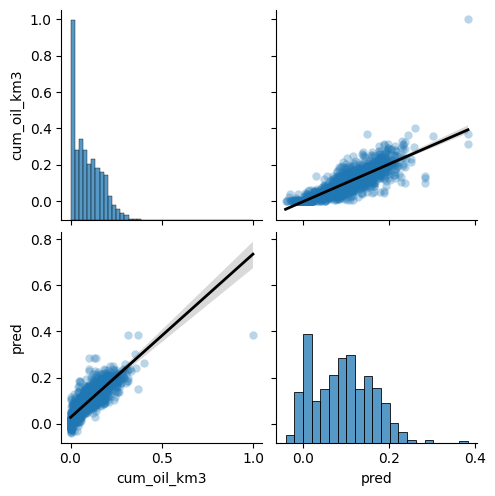

In [111]:
sns.pairplot(
    dbplot_train.drop(["error", "Xcoor", "Ycoor"], axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

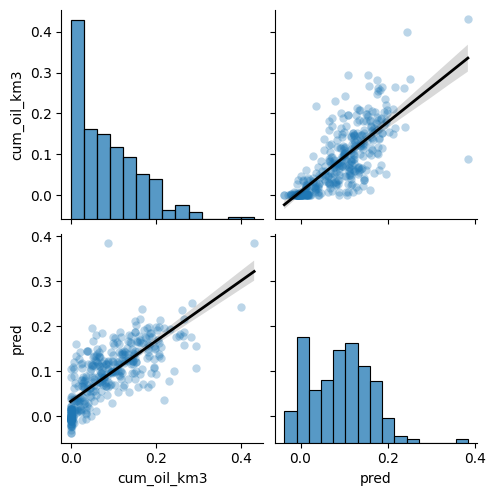

In [112]:
sns.pairplot(
    dbplot_test.drop(["error",'Xcoor', 'Ycoor'], axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

### Analisis geoespacial de los residuos

In [113]:
Ierror = esda.moran.Moran(abs(residuals), knn)

In [114]:
print(
    "Errors  moransI: "
    + str(Ierror.I)
    + "  Z_I: "
    + str(Ierror.z_norm)
    + " p-value: "
    + str(Ierror.p_sim)
)

Errors  moransI: 0.19084829516059773  Z_I: 27.204805273161334 p-value: 0.001


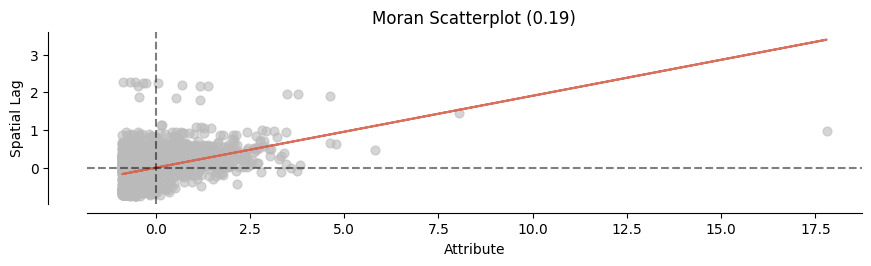

In [115]:
fig, ax = plt.subplots(figsize=(10, 20))
esdaplot.moran_scatterplot(Ierror, ax=ax)
plt.show()

In [116]:
lisa = Moran_Local(residuals, knn)

In [117]:
clusters = lisa.q
lisa.p_sim
sig = lisa.p_sim < 0.05      # True / False
clusters_sig = clusters.copy()
clusters_sig[~sig] = 0  # set non-significant to 0

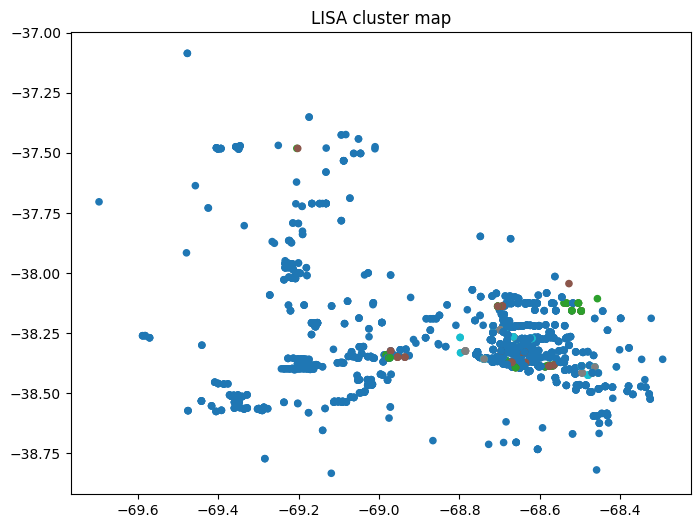

In [118]:
X = db["Xcoor"].values
Y = db["Ycoor"].values
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=clusters_sig, cmap="tab10", s=20)
plt.title("LISA cluster map")
plt.show()

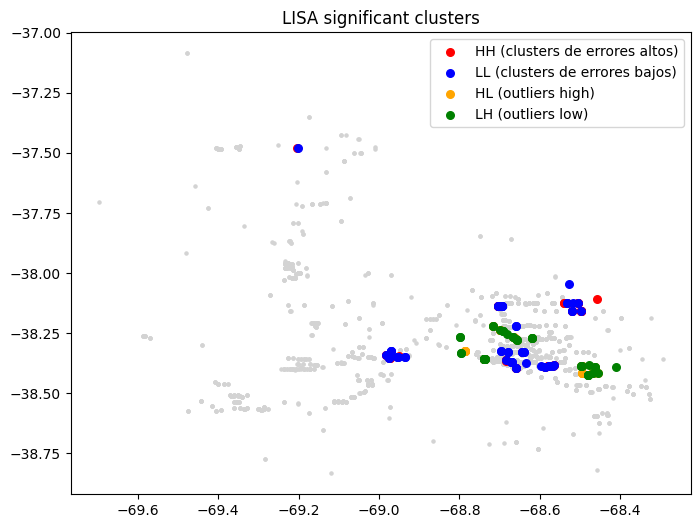

In [119]:
hh = (clusters == 1) & sig
ll = (clusters == 2) & sig
hl = (clusters == 3) & sig
lh = (clusters == 4) & sig

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c="lightgray", s=5)

plt.scatter(X[hh], Y[hh], c="red", s=30, label="HH (clusters de errores altos)")
plt.scatter(X[ll], Y[ll], c="blue", s=30, label="LL (clusters de errores bajos)")
plt.scatter(X[hl], Y[hl], c="orange", s=30, label="HL (outliers high)")
plt.scatter(X[lh], Y[lh], c="green", s=30, label="LH (outliers low)")

plt.legend()
plt.title("LISA significant clusters")
plt.show()

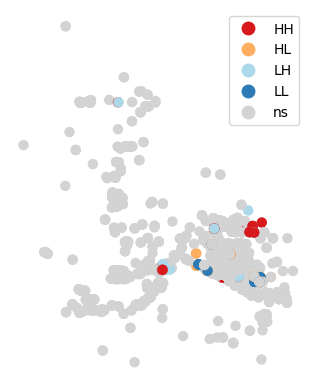

In [120]:
geometry = [Point(xy) for xy in zip(db["Xcoor"], db["Ycoor"])]
gdf = gpd.GeoDataFrame(db, geometry=geometry)
esdaplot.lisa_cluster(lisa, gdf)
plt.show()

In [121]:
g_local = G_Local(residuals, knn)

In [122]:
g_local.Zs  # Z-score por pozo
g_local.p_sim  # p-value por pozo (por simulación/permutaciones)
Zs = g_local.Zs
pvals = g_local.p_sim

sig = pvals < 0.05  # significativos

hotspots = (Zs > 0) & sig
coldspots = (Zs < 0) & sig

In [123]:
print("Hotspots:", hotspots.sum())
print("Coldspots:", coldspots.sum())

Hotspots: 115
Coldspots: 76


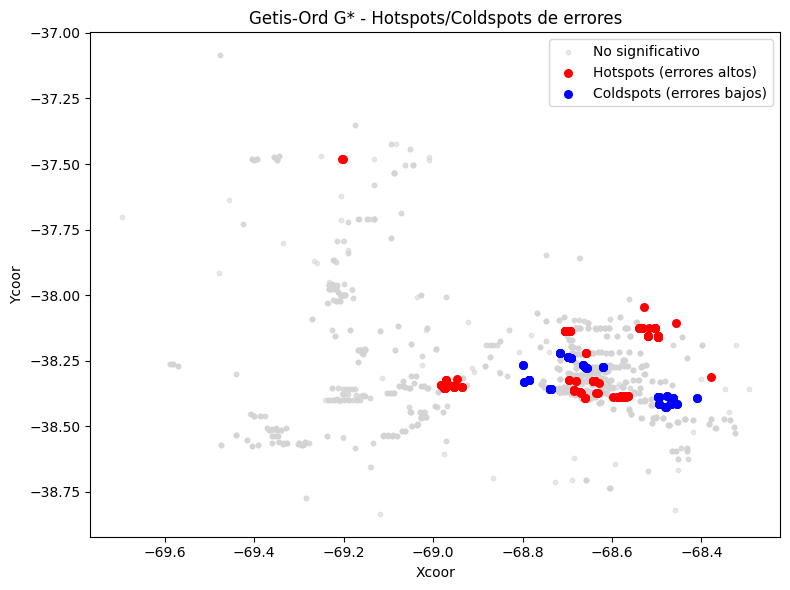

In [124]:
plt.figure(figsize=(8, 6))

plt.scatter(X, Y, c="lightgray", s=10, alpha=0.5, label="No significativo")
plt.scatter(X[hotspots], Y[hotspots], c="red", s=30, label="Hotspots (errores altos)")
plt.scatter(
    X[coldspots], Y[coldspots], c="blue", s=30, label="Coldspots (errores bajos)"
)

plt.xlabel("Xcoor")
plt.ylabel("Ycoor")
plt.title("Getis-Ord G* - Hotspots/Coldspots de errores")
plt.legend()
plt.tight_layout()
plt.show()

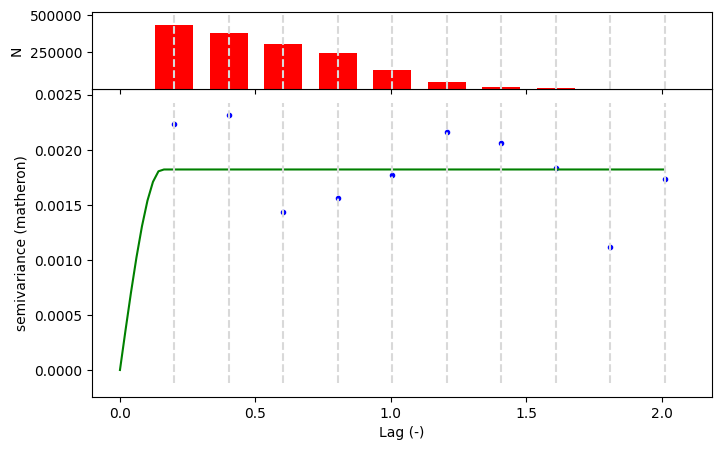

In [125]:
coordinates = np.column_stack((db["Xcoor"].values, db["Ycoor"].values))
V = skg.Variogram(coordinates, residuals)
V.plot()
plt.show()

In [126]:
lag_e = lag_spatial(knn, residuals)
corr = np.corrcoef(residuals, lag_e)[0, 1]
print("Spatial Lag Correlation:", corr)

Spatial Lag Correlation: -0.058301005644610264


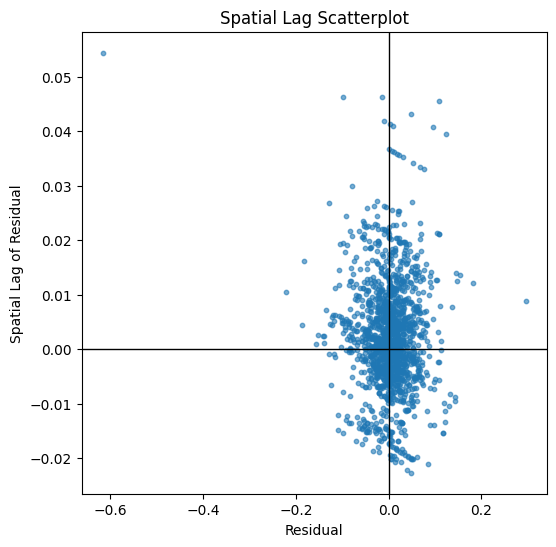

In [127]:
plt.figure(figsize=(6, 6))
plt.scatter(residuals, lag_e, s=10, alpha=0.6)
plt.axhline(0, color="k", linewidth=1)
plt.axvline(0, color="k", linewidth=1)
plt.xlabel("Residual")
plt.ylabel("Spatial Lag of Residual")
plt.title("Spatial Lag Scatterplot")
plt.show()

In [128]:
beta = np.polyfit(residuals, lag_e, 1)[0]
print("Spatial lag slope:", beta)

Spatial lag slope: -0.012362730688814227


#### Referencias

* https://github.com/dizhu-gis/SRGCNN

**Referencias Adicionales**

- **PyTorch Documentation:** [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
- **Scikit-Learn Nearest Neighbors:** [https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)
- **Graph Convolutional Networks Tutorial:** [https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)
- **Geographically Weighted Regression:** [https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf](https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf)